In [1]:
import numpy as np
from scipy.io import wavfile
from matplotlib import pyplot as plt

In [2]:
#file = "string_1.wav"
file = "truck.wav"
sample_rate, signal = wavfile.read(file)
signal = signal[:, 0]
print(sample_rate)

48000


In [3]:
seconds_to_delay = 0.3
frame_delay = int(seconds_to_delay * sample_rate)
attenuation = 0.5

In [4]:
def delay_filter(signal, attenuation, time_delay):
    """ 
    s[t] = e[t] + alpha * e[t-delay]
    """
    #left-zero-pad the signal by time_delay-1
    padded_signal = np.pad(signal, (time_delay-1, 0), 'constant', constant_values=(0, 0))
    #remove frames unnecessary for the delay and now will match dimensions
    padded_signal = padded_signal[:-time_delay+1]
    #add the delayed signal to the original signal
    new_signal = signal + attenuation * padded_signal
    return new_signal

In [5]:
dirac = np.zeros(frame_delay)
dirac[0] = 1

filtered_dirac = delay_filter(dirac, attenuation, frame_delay)

Text(0, 0.5, 'Amplitude')

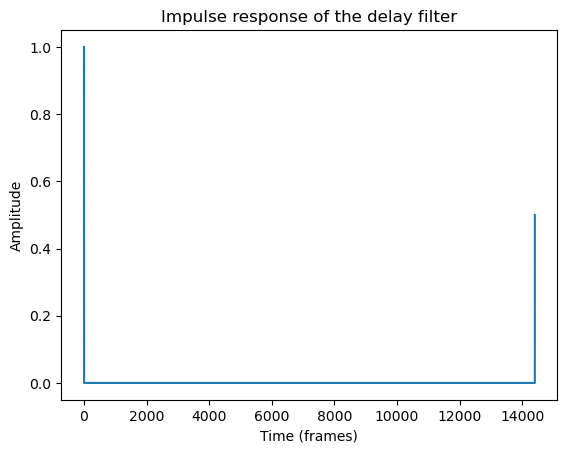

In [9]:
plt.plot(filtered_dirac, label="dirac")
plt.title("Impulse response of the delay filter")
plt.xlabel("Time (frames)")
plt.ylabel("Amplitude")

In [10]:
#the impulse response is the same as the filtered dirac
#prove somehow?

In [62]:
def fir(signal, impulse_response):
    """
    -----------
    """
    signal_padded = np.pad(signal, (len(impulse_response)-1, 0), 'constant', constant_values=(0, 0))
    new_signal = np.convolve(signal_padded, impulse_response, mode='valid')
    return new_signal

In [65]:
len(new_signal)

378393

In [66]:
new_signal = fir(signal, filtered_dirac)

Text(0, 0.5, 'magnitude (dB)')

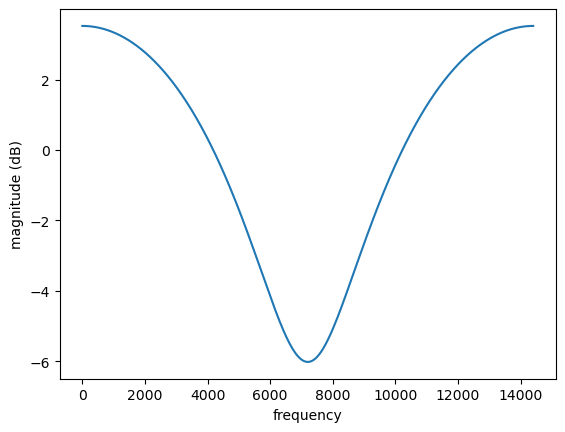

In [81]:
#frequency_response = np.fft.fft(filtered_dirac)

from scipy.signal import CZT

czt_freq = CZT(len(filtered_dirac))
frequency_response = czt_freq(filtered_dirac)


#plt.plot(np.abs(frequency_response), label="frequency response")
#plt.xlabel("frequency")
#plt.ylabel("magnitude")

#convert frequency response unit to decibel
frequency_response_db = 20 * np.log10(np.abs(frequency_response))
plt.plot(frequency_response_db, label="frequency response")
plt.xlabel("frequency")
plt.ylabel("magnitude (dB)")

In [67]:
delay_filter_signal = delay_filter(signal, attenuation, frame_delay)

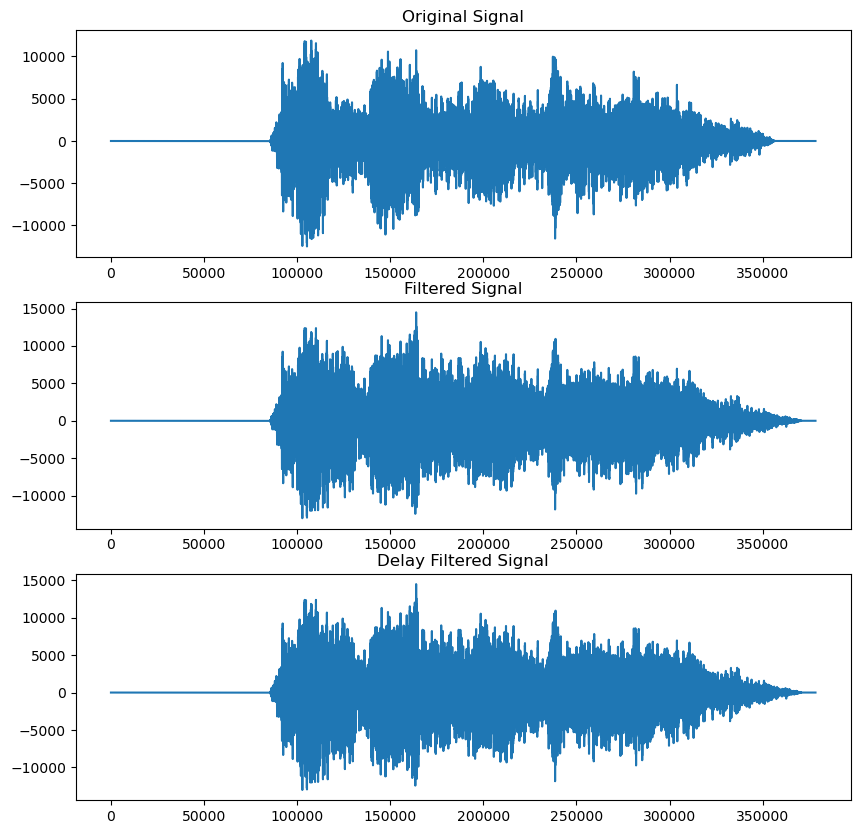

In [68]:
#plot side by side
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
axs[0].plot(signal)
axs[0].set_title('Original Signal')
axs[1].plot(new_signal)
axs[1].set_title('Filtered Signal')
axs[2].plot(delay_filter_signal)
axs[2].set_title('Delay Filtered Signal')
plt.show()

In [70]:
(new_signal - delay_filter_signal).sum()

0.0

In [183]:
#play the signal
from IPython.display import Audio
Audio(signal, rate=sample_rate)

In [184]:
Audio(new_signal, rate=sample_rate)